***
# Deep $Q$-Learning

In our previous notebook, we learned about $Q$-learning. This is an algorithm that learns the expected discounted returns of choosing certain actions $a_t$ in certain states $s_t$. We did this by initializing a **table** of $Q$-values of size $\lvert \mathcal{S} \rvert \times \lvert \mathcal{A} \rvert$, so that for any state-action pair $(s_t, a_t)$ we had a prediction for its $Q$ value. The difficulty arises when $\mathcal{S}$ is continuous (can take on infinite values). In these cases, our `gym` environment would have a `Box` type for its `observation_space`. Since we generally will only visit any state-action pair once, a tabular approach is impossible.

***
### Function Appoximators

In these cases, we instead use a **function approximator** for $Q$. The idea is that if we have a good guess for what $Q(s_t, a_t)$ is, then we should be able to predict $Q(s_t, a_t)$ for similar states and actions, even if we have never seen that state-action pair before. A **differentiable** function approximator is exactly that: a function that gives similar outputs given similar inputs.

There are many differentiable function approximators. You have have heard of linear regressions and logistic regressions. We can abstractly define a function approximator as a set of parameters $\theta$. For example, in a simple quadratic regression of the form
$$
\hat{y} = a x^2 + b x + c
$$
we would have $\theta = \left[ a, b, c \right]$.

***
### Gradient Descent and Loss Functions
When a function approximator is differentiable, we have an additional tool at our disposal: **gradient descent**. Gradient descent is a tool for optimizing any differentiable function. The **gradient** of a function $f$ with respect to some parameters $\theta$ is denoted $\nabla_\theta f$, and is a vector of partial derivatives of $f$ with respect to each variable in $\theta$. For example, $\nabla_\theta \hat{y}$ would be
$$
\begin{bmatrix}
x^2 \\
x \\
1
\end{bmatrix}
$$

Imagine some dataset $(X, Y)$ that we are interested in modelling, and we have a suspicion that the relationship between $X$ and $Y$ is quadratic. Then we can use a function like the one described above ($ax^2 + bx + c$) to try to model the dataset.

Given a data point $(x, y)$, we want the difference between our functions output $\hat{y}$ and the true value $y$ to be small. We use the *squared-error* to measure this difference: $\left(y - \hat{y} \right)^2$. If our function approximator $\theta$ *minimizes* the average squared error over all data points, then we say our function successfully models the data.

We define a **loss function** with respect to the model parameters $\theta$ that we want to minimize. In accordance with our description above, we get:
$$
L(\theta) = \frac{1}{N} \sum_{(x, y) \in (X, Y)} \left(\hat{y} - y \right)^2
$$
where $N$ is the size of the dataset and $\hat{y} = ax^2 + bx + c $.

We can iteratively modify our paramaters $\theta$ so as to minimize this loss function. If we take the gradient of the loss function with respect to $\theta$ and we subtract that from $\theta$, then we get new values for $\theta$ such that the value $L(\theta)$ is smaller. This gives us **gradient descent**:
$$
\theta \gets \theta + \alpha \nabla_\theta L(\theta)
$$
where $\alpha$ is a factor called the **learning rate** that determines how much we change the network parameters with each application of gradient descent. We perform gradient descent for a given number of **epochs** until we are satisfied that our function does a good approximation.

In this case, we can easily analytically compute this:
$$
\nabla_\theta L(\theta) = \frac{1}{N} \sum_{(x, y) \in (X, Y)} 2(\hat{y} - y) \nabla_{\theta} \hat{y}
$$

where $\nabla_\theta \hat{y}$ is as descibed above.

In [1]:
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
sns.set()

In [2]:
def plot(X, Y, Y_hat):
    data = pd.DataFrame({"X":X, "Y":Y, "Y_hat":Y_hat})
    sns.scatterplot(x="X", y="Y", data=data)
    plt.plot(X, Y_hat, color="orange")
    plt.show()

In [3]:
N = 50
a, b, c = 2, -1, 4
X = np.linspace(-1, 1, N)
Y = a*X**2 + b*X + c + np.random.randn(N)*0.1

In [4]:
theta = np.random.rand(3) # a, b, c estimates
Y_hat = theta[0]*X**2 + theta[1]*X + theta[2]

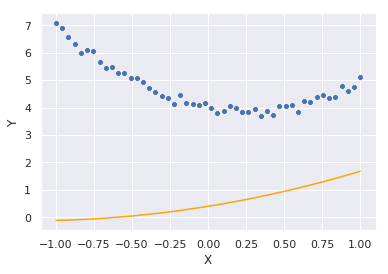

In [5]:
plot(X, Y, Y_hat)

In [6]:
def learn(X, Y, theta, alpha=1e-1, epochs=100):
    N = len(X)
    for e in range(epochs):
        Y_hat = theta[0]*(X**2) + theta[1]*X + theta[2] # predictions
        nabla_theta_y_hat = np.array([
            X**2,
            X,
            np.ones(N)
        ])
        nabla_theta_L = np.mean(2*(Y_hat - Y)*nabla_theta_y_hat, axis=1) # take the average over all datapoints
        
        theta = theta - alpha*nabla_theta_L # gradient descent
    return theta

In [7]:
learned_theta = learn(X, Y, theta)
Y_hat = learned_theta[0]*X**2 + learned_theta[1]*X + learned_theta[2]

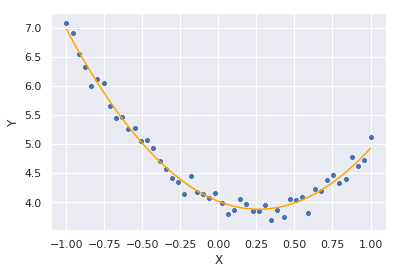

In [8]:
plot(X, Y, Y_hat)

***
### $Q$-learning as a Regression Problem

When we first learned about $Q$-learning, we used the Bellman equation to learn the $Q$ function:
$$
Q(s_t, a_t) \gets Q(s_t, a_t) - \alpha \left(r_t + \gamma Q(s_{t+1}, a_{t+1}) - Q(s_t, a_t) \right)
$$

Compare this to gradient descent for a regression problem:
$$
\theta \gets \theta - \alpha 2 \left( \hat{y} - y \right) \nabla_\theta \hat{y}
$$

These methods are essentially analogous: we update parameters about our function in a manner proportional to the difference between our prediction and the 'true' value. The difference for tabular $Q$-learning is that we essentially have a different parameter for each state-action pair.

***
### Tensorflow and Autodifferentiation

It can be extremely cumbersome to manually compute the derivative of our functions. It becomes much more complex when our functions are highly composed, where we combine the results of many intermediate calculations to produce our result. Instead, we can rely on libraries that provide **autodifferentiation**. There are many approaches to autodifferentiation, with the notion of a 'gradient tape' being used in [`tensorflow 2`](https://www.tensorflow.org/alpha) and [`pytorch`](https://pytorch.org/). Most guides, resources and open-source implementations that you will find today are built using `tensorflow`, a python library that allows us to define complex **computation graphs** with built-in differentiation. Tensorflow is preferred for many reasons (though the gap may be closing), but using computation graphs can feel weird to a new user.

In [9]:
import tensorflow as tf

Tensorflow has [extensive documentation](https://www.tensorflow.org/guide/low_level_intro) that I suggest you spend some time reading, since my goal is not to reproduce the tensorflow guide here. I assume you have a basic understanding of how tensorflow works.

Let us first demonstrate the above regression problem using tensorflow before moving into more complex territory.

In [10]:
N = 50
a, b, c = 2, -1, 4
X = np.linspace(-1, 1, N)
Y = a*X**2 + b*X + c + np.random.randn(N)*0.1

In [11]:
X_ph = tf.placeholder(shape=(50,), dtype=tf.float32) # a placeholder for values, that we will later feed X into
theta = tf.get_variable("theta", initializer=tf.random_normal(shape=(3,))) # our parameters
Y_hat = theta[0]*(X_ph**2) + theta[1]*X_ph + theta[2] # our prediction

Instructions for updating:
Colocations handled automatically by placer.


In [12]:
sess = tf.Session() # used to give tensors in the computation graph values
sess.run(tf.global_variables_initializer()) # initialize defined ops and variables

Y_hat_run = sess.run(Y_hat, 
                    feed_dict = {
                        X_ph: X
                    }) # get initial predictions

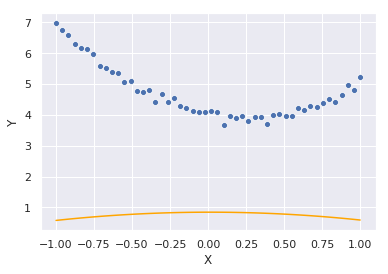

In [13]:
plot(X, Y, Y_hat_run)

In [14]:
L_theta = tf.reduce_mean((Y - Y_hat)**2) # same loss as before
alpha = 1e-1 # learning rate
optimizer = tf.train.GradientDescentOptimizer(alpha).minimize(L_theta) # autodifferentiation!

In [15]:
epochs = 100
for e in range(epochs):
    sess.run([theta, L_theta, optimizer], 
            feed_dict = {
                X_ph:X
            }) # run the autodiff optimizer

In [16]:
Y_hat_run = sess.run(Y_hat, 
                    feed_dict = {
                        X_ph: X
                    }) # get new predictions

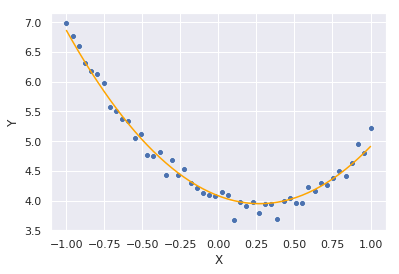

In [17]:
plot(X, Y, Y_hat_run)

### FrozenLake with Tensorflow

Before diving deep into using techniques like deep neural networks, I want to show you how we might do $Q$-learning in tensorflow using the same `FrozenLake-v0` environment from earlier.

We make many changes: rather than calling functions like `act()` and `update()`, instead we make this functionality available as a tensorflow op that is a member variable of the class. This way, we can do things like `sess.run(agent.update, ...` to update, rather than call `agent.update()`.

Tensorflow requires a different kind of understanding of a program. Every statement in a normal python program (`if-else` blocks, assignment, indexing an array, etc) should be converted into an equivalent tensorflow op, so that the entire computation graph represents the program in an abstract way. For now, this may seem unnecessarily obtuse, but the truth is that when we get into more advanced techniques, it will be advantageous for us to define as much of the program in tensorflow as possible.

In [18]:
class Agent:
    def __init__(self, num_states, num_actions, epsilon_i=1.0, epsilon_f=0.0, n_epsilon=10000, alpha=0.1, gamma = 0.99):
        self.epsilon_i = tf.constant(epsilon_i, dtype=tf.float32) # initial epsilon value
        self.epsilon_f = tf.constant(epsilon_f, dtype=tf.float32) # final epsilon value
        self.epsilon = tf.get_variable("epsilon", initializer=tf.constant(epsilon_i, dtype=tf.float32)) # current epsilon value
        self.n_epsilon = tf.constant(n_epsilon, dtype=tf.float32) # number of timesteps over which to decay epsilon
        self.num_states = tf.constant(num_states, dtype=tf.int32)
        self.num_actions = tf.constant(num_actions, dtype=tf.int32)
        self.alpha = tf.constant(alpha, dtype=tf.float32) # learning rate
        self.gamma = tf.constant(gamma, dtype=tf.float32) # discount factor
        self.Q = tf.get_variable("Q", initializer = tf.zeros(shape=(num_states, num_actions))) # initial Q values as a table
        
        self.s_t_ph = s_t = tf.placeholder(dtype=tf.int32, shape=(), name="s_t_ph") # placeholder for states, which is needed to predict Q values
        
        ### act ###
        p = tf.random_uniform(shape=(), minval=0, maxval=1, dtype=tf.float32) # random number, equivalent to np.random.rand()
        
        # tf.cond is the tensorflow version of an if statement as an op, which has a condition, a function that returns tensorflow ops corresponding to if the condition is true, and a function that returns tensorflow ops corresponding to if the condition is false
        self.act = tf.cond(p < self.epsilon, # epsilon-greedy
                          lambda: tf.random_uniform(shape=(), minval=0, maxval=self.num_actions, dtype=tf.int32), # random action. using tf.int32 makes it return integers
                          lambda: tf.argmax(self.Q[s_t], output_type=tf.int32)) # greedy policy
        
        ### update ###
        self.r_t_ph = r_t =tf.placeholder(dtype=tf.float32, shape=(), name="r_t_ph") # equivalent to the r_t parameter in agent.update(...)
        self.a_t_ph = a_t = tf.placeholder(dtype=tf.int32, shape=(), name="a_t_ph") # equivalent to the a_t_next parameter in agent.update(...)
        self.s_t_next_ph = s_t_next = tf.placeholder(dtype=tf.int32, shape=(), name="s_t_next_ph") # equivalent to the s_t_next parameter in agent.update(...)
        a_t_next = tf.cond(p < self.epsilon, # epsilon-greedy
                          lambda: tf.random_uniform(shape=(), minval=0, maxval=self.num_actions, dtype=tf.int32), # random action
                          lambda: tf.argmax(self.Q[s_t_next], output_type=tf.int32)) # greedy policy. we need to define it like we defined self.act.
        
        TD = r_t + self.gamma*self.Q[s_t_next, a_t_next] # the TD-target
        TD = tf.stop_gradient(TD) # treat the TD-target as a constant when using autodifferentiation
        predicted_Q = self.Q[s_t, a_t] # our prediction for Q
        self.loss = (TD - predicted_Q)**2 # the squared error between our prediction and the TD target
        self.update = tf.train.GradientDescentOptimizer(self.alpha).minimize(self.loss) # use gradient descent to minimize the regression loss
        
        ### decay_epsilon ###
        self.decay_epsilon = tf.assign(self.epsilon, # tensorflow op for assigning values to a variable
                                      tf.maximum( 
                                          self.epsilon_f, # if epsilon_f is bigger, use that
                                          self.epsilon - (self.epsilon_i - self.epsilon_f)/self.n_epsilon) # otherwise decay epsilon
                                      )

In [19]:
import gym
env = gym.make("FrozenLake-v0")

In [20]:
num_states = env.observation_space.n
num_actions = env.action_space.n
agent = Agent(num_states, num_actions)

Our agent will be run using the same parameters as the one from the original $Q$-learning notebook. However, for now, this will take significantly longer than just using numpy alone.  We are making calls to `sess.run` but we are not doing a signicant amount of work, making the calls relatively expensive compared to the amount of work that they are doing. We will see later that the more work that is done in a `sess.run` call, the more efficient it becomes. Be patient as the following cell will likely take a few minutes to run.

In [21]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer()) # once we define ops and create our agent, the tensorflow computation graph exists but doesn't have values yet. This gives the abstractly defined operations and variables actual values.
    T = 100000
    s_t = env.reset()

    rewards = []

    for t in range(T):
        a_t = sess.run(agent.act, 
                       feed_dict = {
                            agent.s_t_ph: s_t
        }) # choose an action by running the tensorflow op a_t, passing in the value for s_t into its placeholder s_t_ph

        s_t_next, r_t, done, info = env.step(a_t)
        
        sess.run(agent.update,
                feed_dict = {
                    agent.s_t_ph:s_t,
                    agent.a_t_ph:a_t,
                    agent.s_t_next_ph:s_t_next,
                    agent.r_t_ph:r_t
                }) # minimize the difference between the prediction and the TD target, passing in the values for s_t, a_t, s_t_next and r_t into their respective placeholders
        sess.run(agent.decay_epsilon) # decay epsilon by running the tf op for it
        s_t = s_t_next

        if done:
            rewards.append(r_t)
            s_t = env.reset()

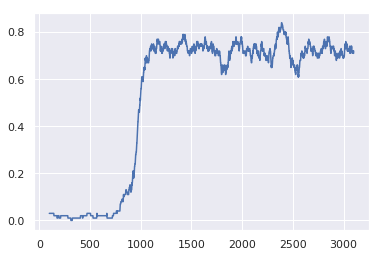

In [23]:
rewards = np.asarray(rewards)
window = 100
running_mean_rewards = pd.Series(rewards, name='q-learning').rolling(window=window).mean()[window-1:] # this slicing is because the first window-1 elements are NaN from the rolling operation.
sns.lineplot(data=running_mean_rewards)

It is *always* a good idea to ensure that your agent is performing better than random. We can essentially run the same loop, but choosing random actions each time.

In [25]:
T = 100000
s_t = env.reset()

random_rewards = []

for t in range(T):
    a_t = env.action_space.sample()
    s_t, r_t, done, info = env.step(a_t)
    
    if done:
        random_rewards.append(r_t)
        s_t = env.reset()

In [26]:
random_rewards = np.asarray(random_rewards)[:len(rewards)] # make sure random_rewards is the same length as rewards. It will generally be much longer, since it will die more frequently causing more rewards to be stored given the same budget of timesteps.
window = 100
running_mean_random_rewards = pd.Series(random_rewards, name='random').rolling(window=window).mean()[window-1:]

In [27]:
compare = pd.concat((running_mean_random_rewards, running_mean_rewards), axis=1) # generate one dataframe holding the terminal rewards from the q-learning agent and the random agent.

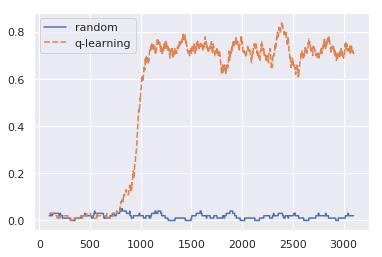

In [28]:
sns.lineplot(data=compare)

I encourage you to compare the definition and running of this program with the one in the earlier $Q$-learning notebook to get a good grasp on the fundamental differences between using libraries like `numpy` directly, versus using `tensorflow`.

***
### Deep $Q$-learning

We have spent the time to learn about differentiable function approximators, $Q$-learning as a regression problem, and autodifferentiation in `tensorflow` for optimization. We have also now seen a complete `tensorflow` program that demonstrates tabular $Q$-learning, using the idea of $Q$-learning as a regression problem. Finally, we are ready to approach **deep $Q$-learning**: using **deep neural networks** to learn the $Q$-function.

Whereas in tabular $Q$-learning, we provide state-action pairs $(s_t, a_t)$ and produce a scalar $Q(s_t, a_t)$ for each one, in deep $Q$-learning we take a different approach. When using neural networks, it is trivial to change the output from a single (scalar) value to multiple (vector) values. Thus, we can define a neural network that accepts as input a state $s_t$ and produces as output a vector of $Q$ values, with each entry in the vector corresponding to an action the agent can take.
![Q-network](../images/)